In [1]:
import pandas as pd
import os
import os.path
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from src.utils.data import getDataPandas, getConfig
from pipe.lut import Model_LUT, Metrics_LUT, Feature_LUT, Plot_LUT
from pipe.stats import stats_analyze

In [2]:
# None-image features
data = getDataPandas()
data = data.sample(frac=1, random_state=1)
data = data.drop_duplicates(subset=['PATNO'], keep='first').reset_index(drop=True)
data = data.drop(data[data['NUPDR3OF'] < 5].index).reset_index(drop=True)
data = data.drop(data[data['LEDD'] > 5000].index).reset_index(drop=True)

In [3]:
model_config = getConfig('model')
data_config = getConfig('data')
img_config = getConfig('image')
group = data_config['data_group']

In [4]:
# Tasks include models used
TASKS = [
    'regression',
    'classification/2'
]
# Features include image features used
FEATURES = [
    ['t1_pca'],
    ['gm_pca']
]

In [5]:
# Maybe write to a specific file later?
log_func = print

Current Task: regression

Image Features:
 ['t1_pca']

SEX chi2 p: 0.4375323086445252
AGE_AT_VISIT Normaltest p_train: [0.2122945], p_test: [0.24669171]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-0.22495]), pvalue=array([0.82233707]))
NUPDR3OF Normaltest p_train: [0.08814091], p_test: [0.47348557]
NUPDR3OF t-test p: Ttest_indResult(statistic=array([-0.88479725]), pvalue=array([0.37774099]))
LEDD Normaltest p_train: [3.00727762e-11], p_test: [0.00017998]
LEDD ranksums p: RanksumsResult(statistic=array([0.82578448]), pvalue=array([0.40892636]))
DURATION Normaltest p_train: [0.18302525], p_test: [0.36809592]
DURATION t-test p: Ttest_indResult(statistic=array([0.33593591]), pvalue=array([0.73740817]))
SCORE Normaltest p_train: [0.52285893], p_test: [0.83850978]
SCORE t-test p: Ttest_indResult(statistic=array([-0.20651165]), pvalue=array([0.83668297]))
Demo + Clinic:

Model: lasso
r2 train 0.21438583026035885, test 0.08526316732604733


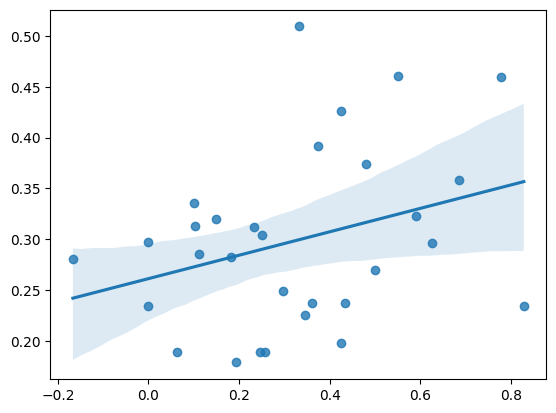

Params {'alpha': 0.2, 'fit_intercept': True}

Model: linear
r2 train 0.225476409302788, test 0.05782035017935172


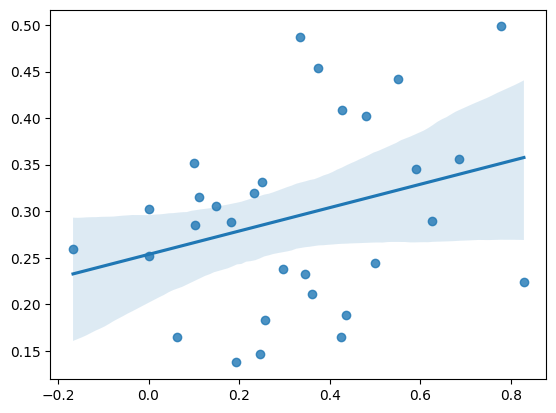

Params {}


Demo + Img:

Model: lasso
r2 train 0.53730846884335, test -0.0814527278379844


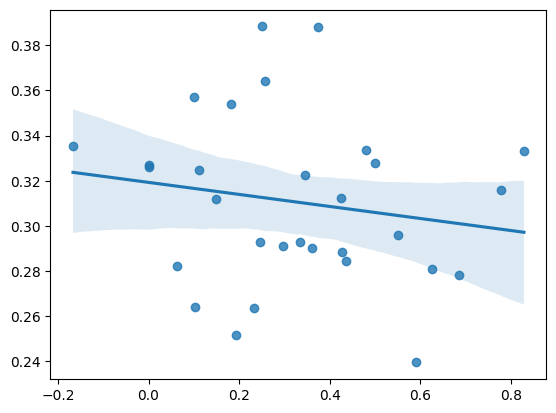

Params {'alpha': 0.2, 'fit_intercept': True}

Model: linear
r2 train 0.6841308539729056, test -0.13937944140867242


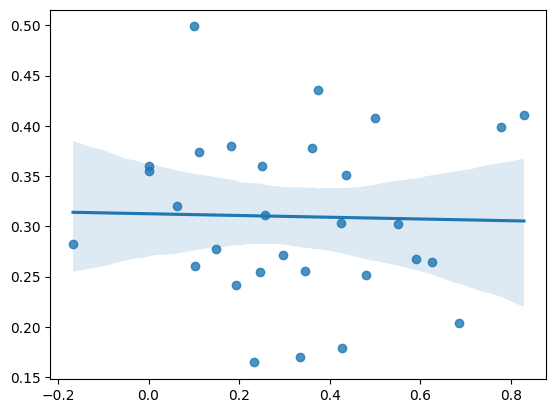

Params {}


Demo + Clinic + Img:

Model: lasso
r2 train 0.613465140667128, test 0.048418245301326546


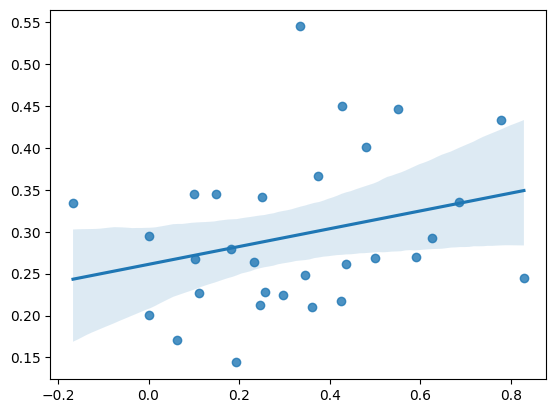

Params {'alpha': 0.2, 'fit_intercept': True}

Model: linear
r2 train 0.7857457291322189, test 0.09118870460733663


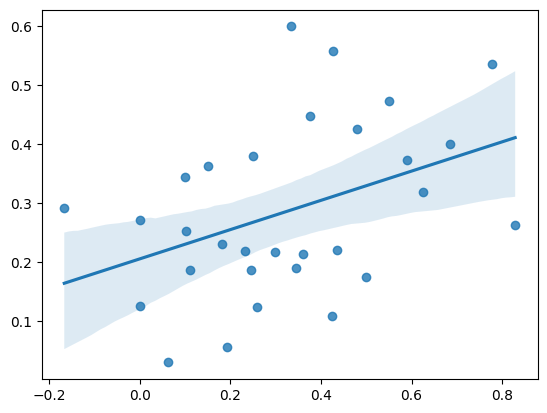

Params {}


Image Features:
 ['gm_pca']

SEX chi2 p: 0.4375323086445252
AGE_AT_VISIT Normaltest p_train: [0.2122945], p_test: [0.24669171]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-0.22495]), pvalue=array([0.82233707]))
NUPDR3OF Normaltest p_train: [0.08814091], p_test: [0.47348557]
NUPDR3OF t-test p: Ttest_indResult(statistic=array([-0.88479725]), pvalue=array([0.37774099]))
LEDD Normaltest p_train: [3.00727762e-11], p_test: [0.00017998]
LEDD ranksums p: RanksumsResult(statistic=array([0.82578448]), pvalue=array([0.40892636]))
DURATION Normaltest p_train: [0.18302525], p_test: [0.36809592]
DURATION t-test p: Ttest_indResult(statistic=array([0.33593591]), pvalue=array([0.73740817]))
SCORE Normaltest p_train: [0.52285893], p_test: [0.83850978]
SCORE t-test p: Ttest_indResult(statistic=array([-0.20651165]), pvalue=array([0.83668297]))
Demo + Clinic:

Model: lasso
r2 train 0.21438583026035885, test 0.08526316732604733


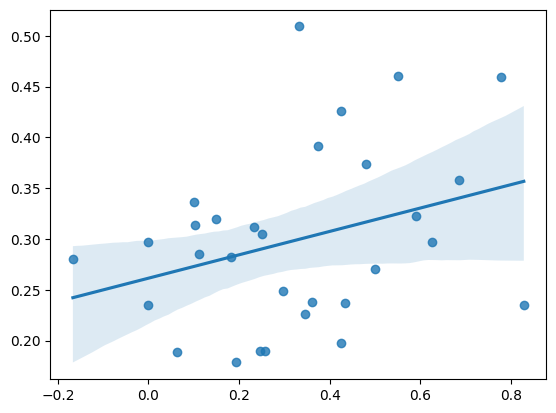

Params {'alpha': 0.2, 'fit_intercept': True}

Model: linear
r2 train 0.225476409302788, test 0.05782035017935172


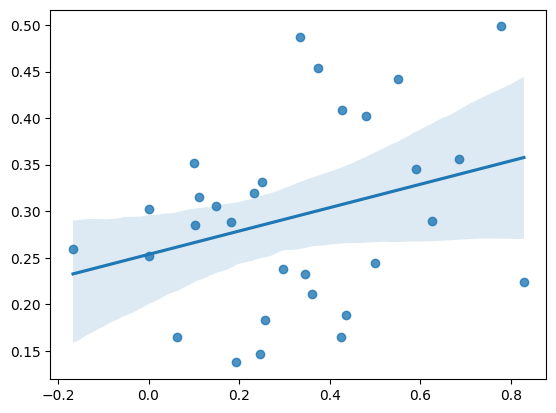

Params {}


Demo + Img:

Model: lasso
r2 train 0.6098397410996834, test -0.14505317385147198


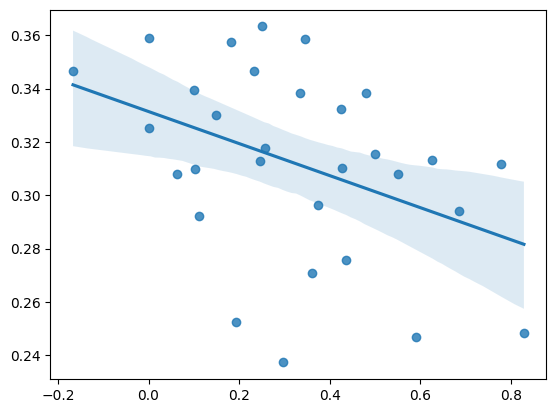

Params {'alpha': 0.2, 'fit_intercept': False}

Model: linear
r2 train 0.6722450596400652, test -0.1344309777908992


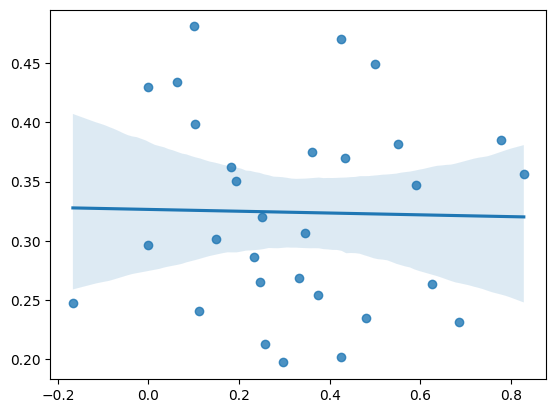

Params {}


Demo + Clinic + Img:

Model: lasso
r2 train 0.7425433309445111, test -0.00916463681605717


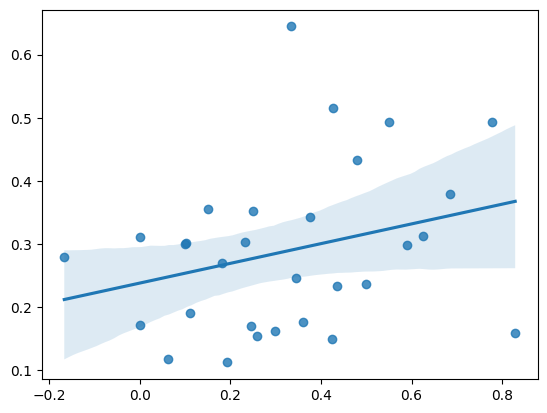

Params {'alpha': 0.2, 'fit_intercept': False}

Model: linear
r2 train 0.8292632548629971, test 0.06847111211011048


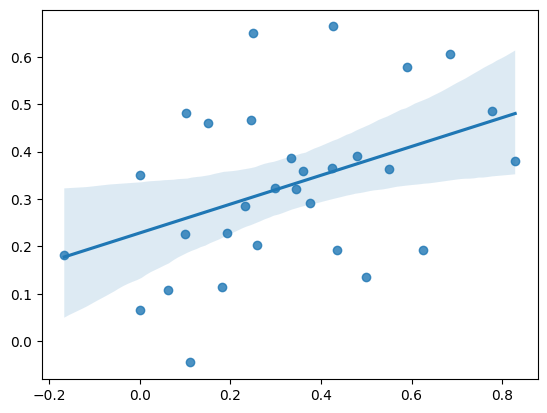

Params {}


Current Task: classification/2

Image Features:
 ['t1_pca']

SEX chi2 p: 0.6122700126944208
CAT chi2 p: 1.0
AGE_AT_VISIT Normaltest p_train: [0.35434886], p_test: [0.06380193]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-1.09796078]), pvalue=array([0.27405412]))
NUPDR3OF Normaltest p_train: [0.11280133], p_test: [0.43054882]
NUPDR3OF t-test p: Ttest_indResult(statistic=array([-0.28887396]), pvalue=array([0.77309327]))
LEDD Normaltest p_train: [2.91352221e-10], p_test: [1.59474083e-06]
LEDD ranksums p: RanksumsResult(statistic=array([1.15755127]), pvalue=array([0.24704721]))
DURATION Normaltest p_train: [0.08684172], p_test: [0.34164922]
DURATION t-test p: Ttest_indResult(statistic=array([0.58189715]), pvalue=array([0.56154583]))
Demo + Clinic:

Model: svc
AUC train 0.7240143369175627, test 0.7433035714285714


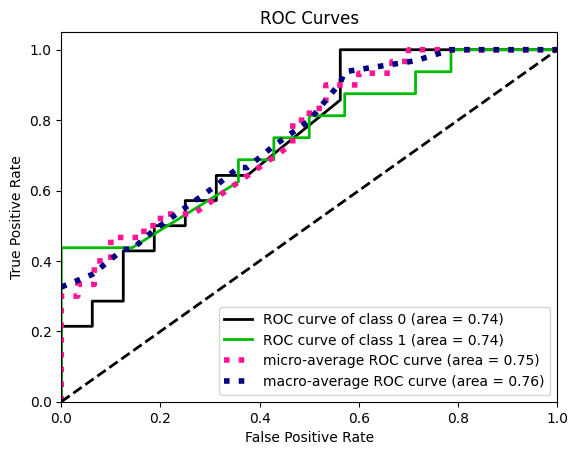

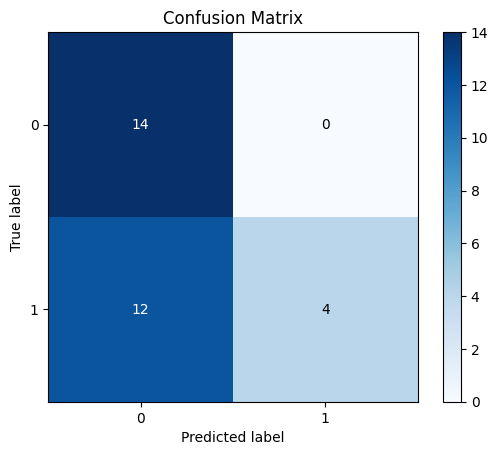

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 0.8673835125448027, test 0.7254464285714286


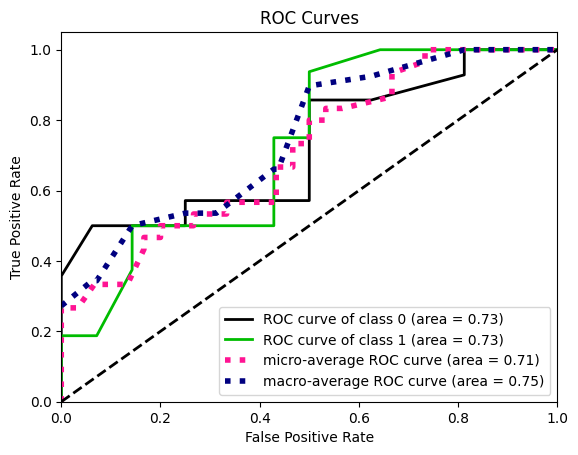

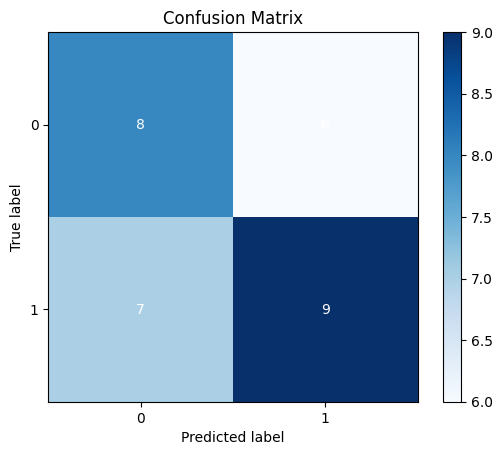

Params {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.9}


Demo + Img:

Model: svc
AUC train 0.0, test 0.41517857142857145


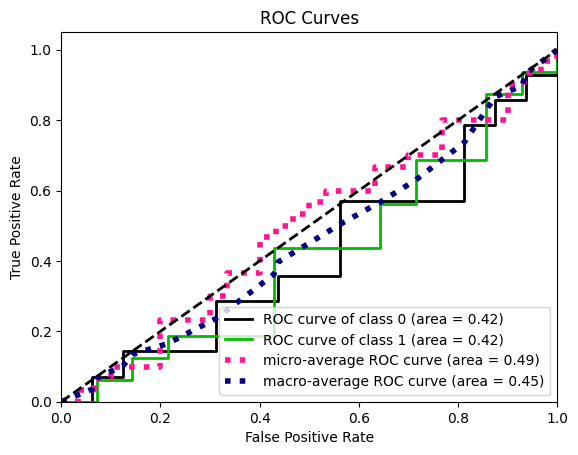

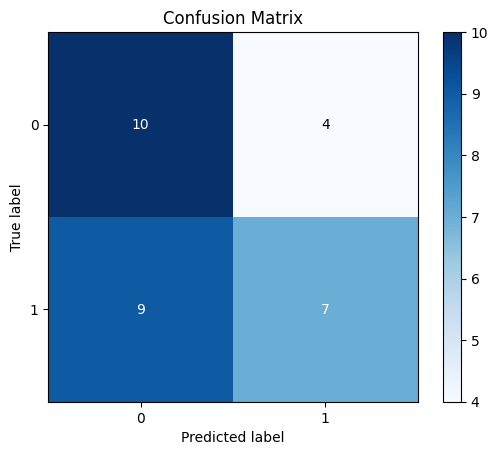

Params {'coef0': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 0.965352449223417, test 0.5044642857142857


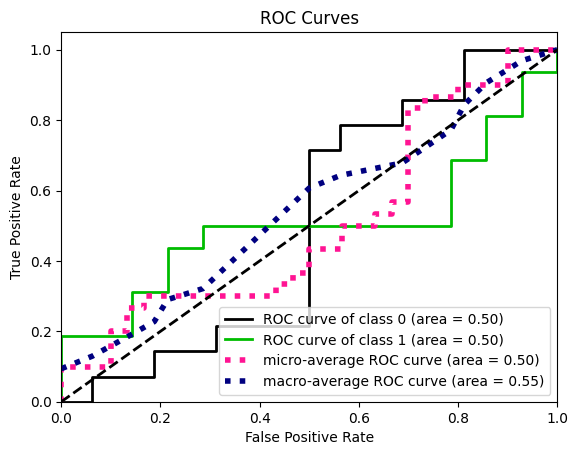

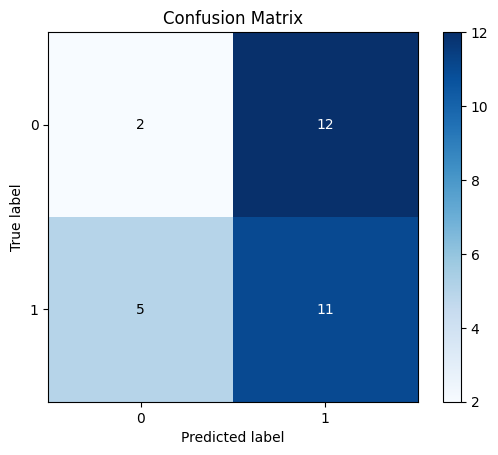

Params {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.85}


Demo + Clinic + Img:

Model: svc
AUC train 0.776284348864994, test 0.7276785714285714


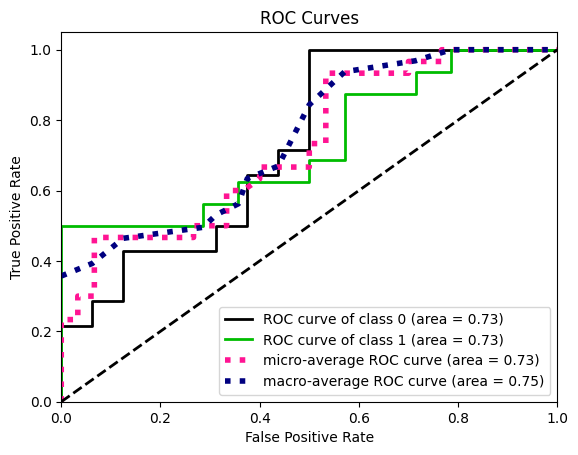

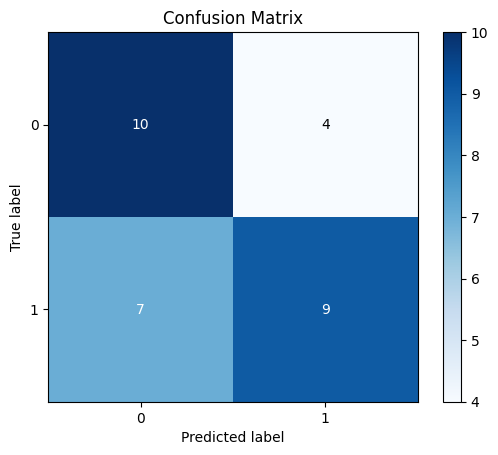

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 1.0, test 0.75


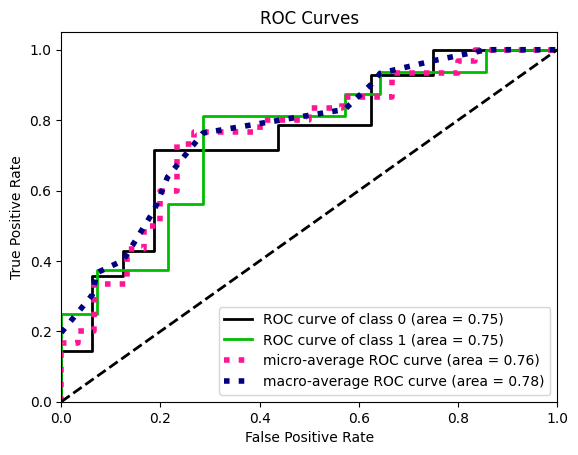

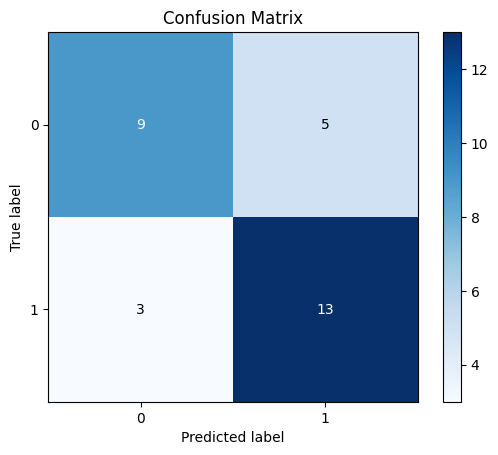

Params {'colsample_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 5, 'missing': -999, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.85}


Image Features:
 ['gm_pca']

SEX chi2 p: 0.6122700126944208
CAT chi2 p: 1.0
AGE_AT_VISIT Normaltest p_train: [0.35434886], p_test: [0.06380193]
AGE_AT_VISIT t-test p: Ttest_indResult(statistic=array([-1.09796078]), pvalue=array([0.27405412]))
NUPDR3OF Normaltest p_train: [0.11280133], p_test: [0.43054882]
NUPDR3OF t-test p: Ttest_indResult(statistic=array([-0.28887396]), pvalue=array([0.77309327]))
LEDD Normaltest p_train: [2.91352221e-10], p_test: [1.59474083e-06]
LEDD ranksums p: RanksumsResult(statistic=array([1.15755127]), pvalue=array([0.24704721]))
DURATION Normaltest p_train: [0.08684172], p_test: [0.34164922]
DURATION t-test p: Ttest_indResult(statistic=array([0.58189715]), pvalue=array([0.56154583]))
Demo + Clinic:

Model: svc
AUC train 0.7240143369175627, test 0

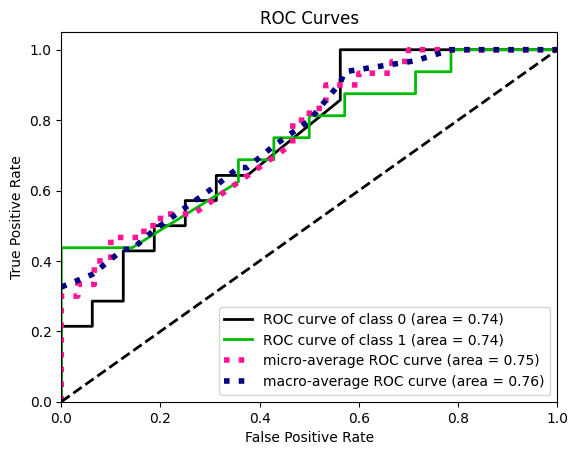

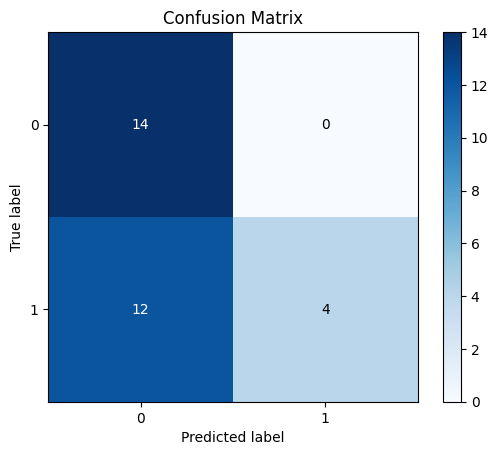

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 0.8673835125448027, test 0.7254464285714286


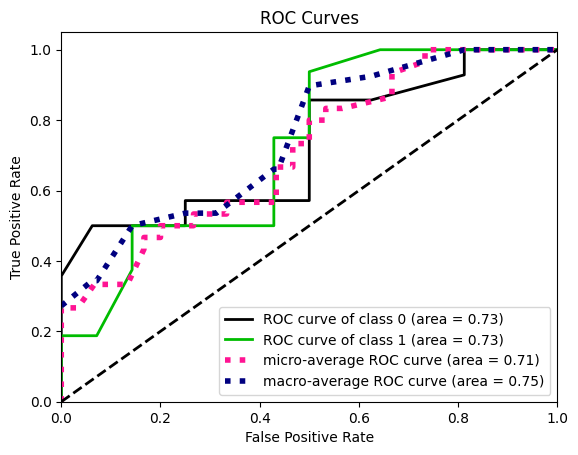

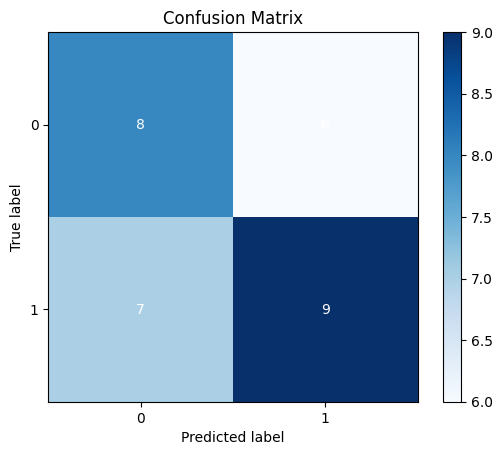

Params {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.9}


Demo + Img:

Model: svc
AUC train 0.0, test 0.5401785714285714


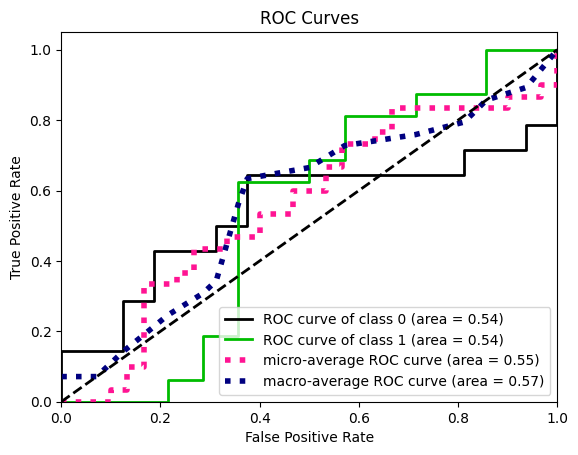

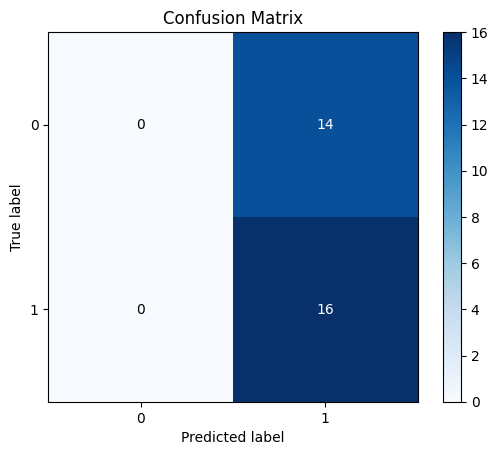

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 1.0, test 0.5758928571428572


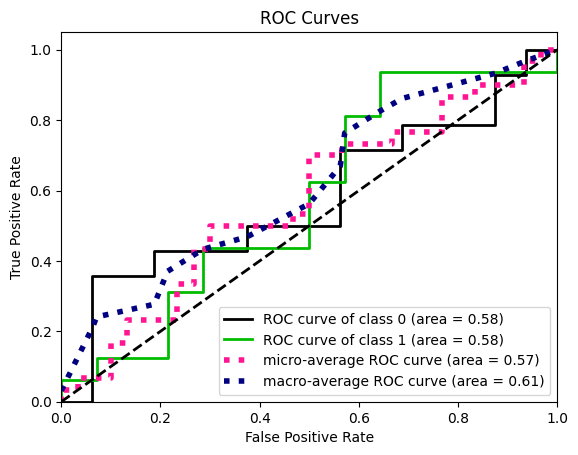

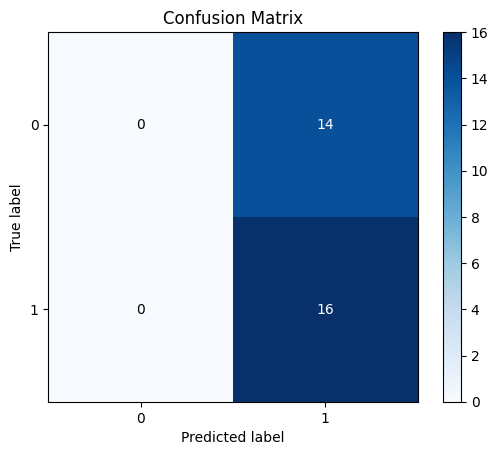

Params {'colsample_bytree': 0.85, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.8}


Demo + Clinic + Img:

Model: svc
AUC train 0.926373954599761, test 0.7723214285714286


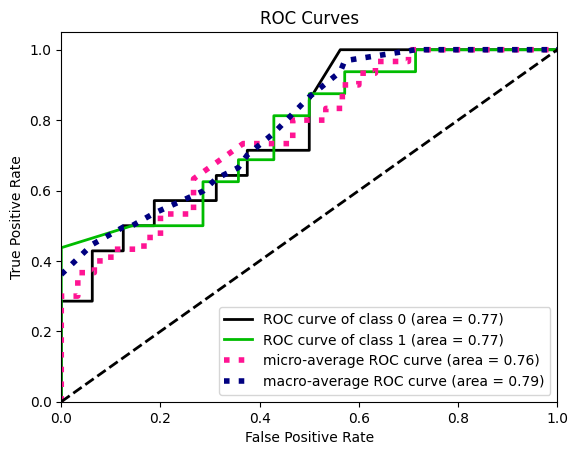

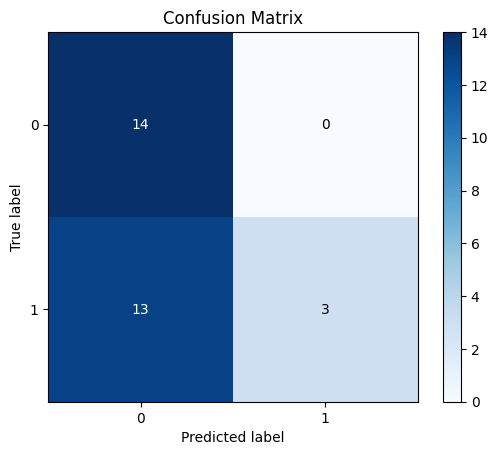

Params {'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'probability': True, 'random_state': 1, 'shrinking': True, 'tol': 0.01}

Model: xgboost
AUC train 1.0, test 0.6651785714285714


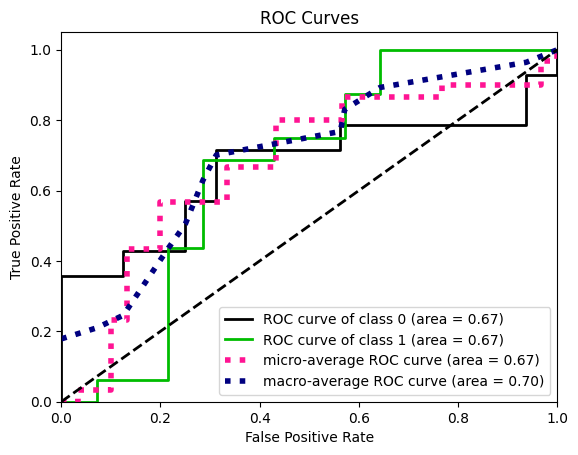

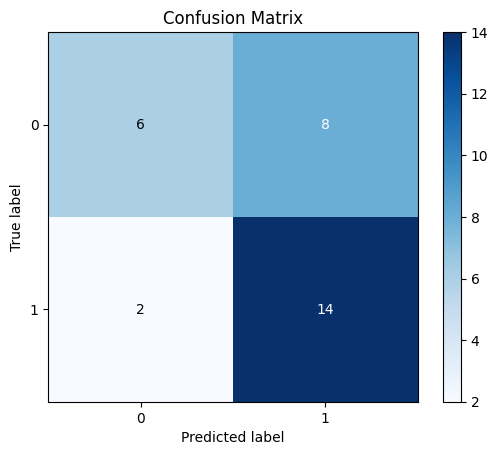

Params {'colsample_bytree': 0.85, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 25, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 1, 'subsample': 0.9}




In [6]:
# Loop for tasks and feature collections
for task_name in TASKS:
    log_func('Current Task: {}'.format(task_name))
    log_func()
    for feature_names in FEATURES:
        log_func('Image Features:\n {}'.format(feature_names))
        log_func()
        # Get model list
        task = model_config['task'][task_name]
        models = task['models']
        metric_list = task['metrics']
        
        # Filter data with demographic and clinical keys
        x = data[group['demo'] + group['clinic']]
        y = data[[task['output']]]
        # Split the dataset (To be overwritten later)
        # Potential solution for dataset split: https://github.com/sdpython/pandas_streaming/blob/a1fa7b9300838c8136edb49312ba2d6209b46cc9/pandas_streaming/df/connex_split.py#L386
        x_clinic_train, x_clinic_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=12, stratify=(y if task['stratify'] else None))
        # Statistical Analysis
        stats_analyze(x_clinic_train, x_clinic_test, y_train, y_test, data_config)
        # Empty dataframes to fill with image features
        x_img_train = pd.DataFrame(index=x_clinic_train.index).reset_index(drop=True)
        x_img_test = pd.DataFrame(index=x_clinic_test.index).reset_index(drop=True)

        # Loop to calculate each feature, multiple features are supported
        for feature_name in feature_names:
            # Get calculation function and params via LUT
            func = Feature_LUT[feature_name]
            params = img_config['task'][feature_name]['params']
            # Calculate features and append to the dataframe
            x_fe_train, x_fe_test = func(data, x_clinic_train.index, x_clinic_test.index, params)
            x_img_train = x_img_train.join(x_fe_train)
            x_img_test = x_img_test.join(x_fe_test)

        # Rearrange data
        # demo + clinic, demo + img, demo + clinic + img
        x_clinic_train = x_clinic_train.reset_index(drop=True)
        x_clinic_test = x_clinic_test.reset_index(drop=True)
        x_demo_train = x_clinic_train[group['demo']]
        x_demo_test = x_clinic_test[group['demo']]
        x_clinic_img_train = x_clinic_train.join(x_img_train)
        x_clinic_img_test = x_clinic_test.join(x_img_test)
        # No demo data in img df
        x_img_train = x_demo_train.join(x_img_train)
        x_img_test = x_demo_test.join(x_img_test)

        x_train_list = [x_clinic_train, x_img_train, x_clinic_img_train]
        x_test_list = [x_clinic_test, x_img_test, x_clinic_img_test]
        info_list = ['Demo + Clinic:', 'Demo + Img:', 'Demo + Clinic + Img:']

        # Loop
        for i in range(3):
            x_train = x_train_list[i]
            x_test = x_test_list[i]
            log_func(info_list[i])
            log_func()
            for model in models:
                name = model['name']
                parameters = model['params']
                model = Model_LUT[name]()
                cv = GridSearchCV(
                    model,
                    parameters,
                    n_jobs=5,
                    # StratifiedGroupKFold?
                    cv=(StratifiedKFold(n_splits=5, shuffle=True, random_state=1) if task['stratify'] else KFold(n_splits=5, shuffle=True, random_state=1)),
                    scoring=task['gridsearch_params']['scoring']
                )
                cv.fit(x_train, y_train.values.ravel())
                best = cv.best_estimator_
                log_func('Model: {}'.format(name))
                # Now classification specific, other metrics need to be considered according to task
                for metric in metric_list:
                    metric_func = Metrics_LUT[metric[0]]
                    # predict_proba True
                    # predic        False
                    pred_func = best.predict_proba if metric[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    # TODO: multiclass support should be implemented via metric_func
                    log_func('{} train {}, test {}'.format(metric[0],
                                                           metric_func(y_train[task['output']].to_numpy(), train_pred),
                                                           metric_func(y_test[task['output']].to_numpy(), test_pred)
                                                           ))
                plot_list = task['plot']
                for plot in plot_list:
                    plot_func = Plot_LUT[plot[0]]
                    pred_func = best.predict_proba if plot[1] else best.predict
                    train_pred = pred_func(x_train)
                    test_pred = pred_func(x_test)
                    plot_func(y_test[task['output']].to_numpy(), test_pred)
                    plt.show()
                log_func('Params {}'.format(cv.best_params_)) # best.get_params()
                log_func()
            log_func()